## Time-series forecast using simple feed-forward neural networks

In [1]:
import numpy as np
import pandas as pd
import datetime

from numpy import linalg as la

from pandas_datareader import data

from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import mean_squared_error

from keras import Sequential, layers, optimizers, losses

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")  

### Load Data
We will use the following dataset https://data.world/perceptron/monthly-car-sales-quebec-1960
about monthly car sales in Quebec from 1960. 
To download the dataset you have to join data.world. If you don't want to, just get it from my github repo.

In [5]:
series = pd.read_csv('csv/monthly-car-sales.csv', header=0, index_col=0)

# transform the index of type DatetimeIndex and rename it
series.index = pd.DatetimeIndex(series.index)
series.index.names = ['date']

Dimension: (108, 1)


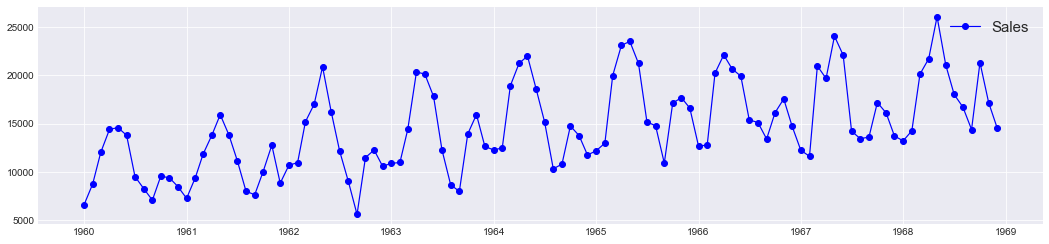

In [6]:
print('Dimension: {}'.format(series.shape))
fig, ax = plt.subplots(1,1, figsize=(18, 4))
ax.plot(series.index, series, 'b-o', linewidth=1.2, label='Sales')
ax.legend(fontsize=15)
ax.grid()
plt.show()

Let us rescale the data using MinMaxScaler

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


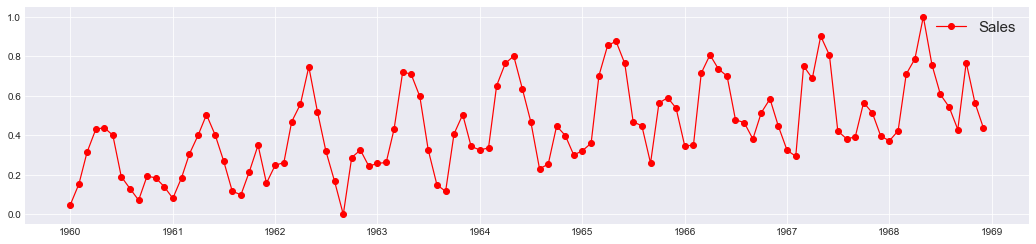

In [9]:
series_mm = scaler.fit_transform(series.values)  
series_mm = pd.DataFrame(data=list(series_mm), columns=["Sales"], index=series.index)

fig, ax = plt.subplots(1,1, figsize=(18, 4))
ax.plot(series_mm.index, series_mm, 'r-o', linewidth=1.2, label='Sales')
ax.legend(fontsize=15)
ax.grid()
plt.show()

### Split the data
Now, let us split the given dataset into train set and test set. 
We take as a test set the data related to 1968.

In [12]:
# We use data for the year 1968 as test set
S_train, S_test = series_mm[:'1967-12-01'], series_mm['1968-01-01':]
print(S_train.shape)
print(S_test.shape)

(96, 1)
(12, 1)


## Transform the univariate series 

When dealing with time series forecast, we want to predict a value at time $t$, given the past data related 
to timeframe $t-n$, where $n$ can be any number of steps. 

In order to use a neural networl, we need to consider our time series forecast problem as a problem that can be solved with a supervised algorithm. To this end, **we need to reshape our series** in terms of **features** and **labels**.

As an example, consider the following simple series:

In [18]:
S = np.array(range(0,20))
S

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

and the following function:

In [19]:
def array_for_forecast(data,npast=1):
    ''' 
        data: np.array column 
        npast: number of past days used for training 
    '''
    if len(data.shape): # == 1
        data = np.reshape(data,(-1,1))
    
    features = []  
    labels   = []  
    for i in range(npast, len(data)):
        features.append( data[i-npast:i, 0] )
        labels.append( data[i, 0] )
    
    df = pd.DataFrame(data = features)
    df['label'] = labels
    return df

In [24]:
df = array_for_forecast(S,15)
df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
3,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
4,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


Here, we see that we consider the previous $15$ (past) data as the *features* of the dataset, and the corresponding $11$-th value is instead the corresponding *label*. In this way, from a time series of $20$ values, we obtain a dataset of $5$ observations, each of them of $15$ features and the associated label. 

Below, we will use the folling equivalent function, which takes in input a DataFrame column but maintains the date as the index and renames features according to the timesteps.

In [26]:
def series_for_forecast(data, npast=1, nforw=0):
    '''
        data : pandas Series (or column of a DataFrame)
        npast: number of past days used for training 
        nforw: number of future days (labels)
    '''
    # copy original DataFrame (Series)
    modata = data.copy()
    modata.columns = ['t']

    # sequence (t-n,...,t-1) of features
    for i in range(npast, 0, -1):
        modata['t-{}'.format(i)] = data.shift(i)
    # forecast sequence (t+1, ... t+n)
    for i in range(1, nforw+1):
        modata['t+{}'.format(i)] = data.shift(-i)

    # reindex the dataframe according to the columns
    cols   = modata.columns[1:npast+1].tolist() + list( 't' ) + modata.columns[npast+1:].tolist() 
    modata = modata.reindex(columns = cols)

    # remove NaN
    modata.dropna(inplace=True)

    # give an error is the dataframe is empty 
    if modata.empty:
        print('*** The output DataFrame is empty!! ***')
        
    return modata

Let us reshape our car sales train set using the past 2 years of data (i.e., 24 values of the series) 

In [29]:
# number of past data used to build the deataset
npast = 24
S_train_mod = series_for_forecast(S_train,npast) 
S_train_mod

,t-24,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
date,,,,,,,,,,,,,,,,,,,,,
1962-01-01,0.047830,0.153914,0.314549,0.429935,0.439287,0.400516,0.191418,0.130680,0.072135,0.193707,...,0.400175,0.504505,0.401977,0.271541,0.117237,0.099459,0.216599,0.350251,0.158200,0.248843
1962-02-01,0.153914,0.314549,0.429935,0.439287,0.400516,0.191418,0.130680,0.072135,0.193707,0.184891,...,0.504505,0.401977,0.271541,0.117237,0.099459,0.216599,0.350251,0.158200,0.248843,0.261994
1962-03-01,0.314549,0.429935,0.439287,0.400516,0.191418,0.130680,0.072135,0.193707,0.184891,0.140665,...,0.401977,0.271541,0.117237,0.099459,0.216599,0.350251,0.158200,0.248843,0.261994,0.469144
1962-04-01,0.429935,0.439287,0.400516,0.191418,0.130680,0.072135,0.193707,0.184891,0.140665,0.081292,...,0.271541,0.117237,0.099459,0.216599,0.350251,0.158200,0.248843,0.261994,0.469144,0.557304
1962-05-01,0.439287,0.400516,0.191418,0.130680,0.072135,0.193707,0.184891,0.140665,0.081292,0.185378,...,0.117237,0.099459,0.216599,0.350251,0.158200,0.248843,0.261994,0.469144,0.557304,0.746773
1962-06-01,0.400516,0.191418,0.130680,0.072135,0.193707,0.184891,0.140665,0.081292,0.185378,0.305343,...,0.099459,0.216599,0.350251,0.158200,0.248843,0.261994,0.469144,0.557304,0.746773,0.518095
1962-07-01,0.191418,0.130680,0.072135,0.193707,0.184891,0.140665,0.081292,0.185378,0.305343,0.400175,...,0.216599,0.350251,0.158200,0.248843,0.261994,0.469144,0.557304,0.746773,0.518095,0.320247
1962-08-01,0.130680,0.072135,0.193707,0.184891,0.140665,0.081292,0.185378,0.305343,0.400175,0.504505,...,0.350251,0.158200,0.248843,0.261994,0.469144,0.557304,0.746773,0.518095,0.320247,0.167016
1962-09-01,0.072135,0.193707,0.184891,0.140665,0.081292,0.185378,0.305343,0.400175,0.504505,0.401977,...,0.158200,0.248843,0.261994,0.469144,0.557304,0.746773,0.518095,0.320247,0.167016,0.000000


In [30]:
# and now separate the train data from the train label
X_train = S_train_mod.drop(columns=['t'])
y_train = S_train_mod['t']
print(X_train.shape)
print(y_train.shape)

(72, 24)
(72,)


## Building the neural network
Now that the time series has been reshaped, lut us build the neural network so that future values can be predicted.  

The function below builds the neural network, according to strucure given by *n_units*, and trains it using 
the *X_train* and the set of labels *y_train*. 

By default, there will be $1$ node in the output layer (we want to obtain only one value), we use *relu* as activation function between layers, we use *adam* optimizer (with a mini-batch size of $64$), 
and the *mean squared error* as loos function. 
The number of epochs is fixed to $25$.

In [31]:
def ffnn(X_train, y_train, n_units):
    # number of input and output nodes of the neural network
    Nin, Nout  = n_units[0], n_units[-1]

    # build the network
    ffnn = Sequential()
    # first hidden layer
    ffnn.add( layers.Dense( n_units[1], activation='relu', input_dim=Nin ) )
    # the rest of hidden layers
    for units in n_units[2:-1]:
        ffnn.add( layers.Dense( units, activation='relu' ) )
    #endfor
    # last (output) layer
    ffnn.add( layers.Dense(Nout) )
    # compile
    ffnn.compile(optimizer=optimizers.adam(), loss=losses.mean_squared_error)
    # summary 
    print('\n> Feed-Forward Neural Network (hl={})'.format(n_units[1:-1]))
    #ffnn.summary()
    
    # train
    mlp = ffnn.fit(x=X_train, y=y_train, batch_size=64, epochs=25, verbose=0)    
    return mlp
#end function

Set initial parameters, namely, 
the number of nodes of the input layer (the number of features), 
the number of nodes in the ouput layer (only $1$), 
and the number of nodes in the hidden layers.

We construct $3$ different networks:

In [32]:
# number of input and output nodes of the neural network
Nin, Nout = X_train.shape[1], 1

# three types of networks
nnstruct = [ [Nin, 128, 64, 32, Nout], [Nin, 100, 100, Nout],  [Nin, 100, 100, 50, Nout] ]

### Forecasting
Now, before training the neural networks, let us also explain how forecasts are made. 

Suppose that we have built out network and trained it with the train set. 
We can start predicting future values, in our case, the $12$ values (of the test set) in positions $97, 98, \dots, 107$ of our time series. 

To predict the $97$-th value, we have to use previous $24$ past values ($97-24$) as $24$ is the number of past data we have decided to use to build the model). The prediction is made by means of the *.predict* function. We obtain some $\widehat{y}_{97}$ value.

In order to predict the $98$-th value, as before, we have to use the previous $24$ past values ($98-24$), but now we have two possibilities. In position $97$, we can either use the true $97$-th value from the test set or we can use the predicted value $\widehat{y}_{97}$. In the first case we say that we are doing a *walk forward* forecast.

The two functions below implement the two possibilities just described:

In [37]:
def mlp_walk_forward(mlp, npast, S_train, S_test):
    past   = [i[0] for i in S_train.values.tolist()]
    future = [i[0] for i in S_test.values.tolist() ]
    predictions = []
    
    # step over each time-step in the test set
    for i in range(len(future)):
        # get current input data (of length npast) to make the 1-step forecast  
        x_input = np.array(past[-npast:]).reshape(1, npast)
        # forecast
        yhat = mlp.model.predict(x_input, verbose=0)
        # save
        predictions.append(np.asscalar(yhat))
        # walk-forward: add the true next observation to 'past' for the next forecast
        past.append(future[i])
    #endfor
    
    return predictions
#endfunction

In [34]:
def mlp_multistep_predict(mlp, npast, S_train, S_test):
    past = [i[0] for i in S_train.values.tolist()]    
    predictions = []
    
    # step over each time-step in the test set
    for i in range(len(S_test)):
        # get current input data (of length npast) to make the 1-step forecast  
        x_input = np.array(past[-npast:]).reshape(1, npast)
        # forecast
        yhat = mlp.model.predict(x_input, verbose=0)
        # save
        predictions.append(np.asscalar(yhat))
        # add the forecasted value yhat to 'past' for the next forecast
        past.append(np.asscalar(yhat))
    #endfor
    
    return predictions
#endfunction

### Build, train, and forecast

In [38]:
mlp    = []
mlpwf  = []
mlpred = []
for k in range(len(nnstruct)):
    # build and fit the network with the train set 
    mlp = ffnn(X_train, y_train, nnstruct[k])
    
    # predict using the test set, i.e., walk-forward prediction
    mlpwf.append( mlp_walk_forward(mlp, npast, S_train, S_test) )
    
    # predict using the forecasted values from mlp
    mlpred.append( mlp_multistep_predict(mlp, npast, S_train, S_test) )
#endfor


 > Feed-Forward Neural Network (hl=[128, 64, 32])

 > Feed-Forward Neural Network (hl=[100, 100])

 > Feed-Forward Neural Network (hl=[100, 100, 50])


We have built the three neural networks, and used them to forecast the monthly sales for the year 1968. Let us see the results. 

First of all, we compute the mean square errors for the three forecast both using the walk-forward 
validation and using the predicted values.

In [39]:
def meansqerr(trueval, predval):
    # mean_squared_error
    return np.sqrt( sum((trueval - predval) **2 ) / len(predval) )[0]

In [40]:
print('walk forward (using test set)')
for k in range(len(nnstruct)):
    print( 'MSE ({}):\t{:.5f}'.format(nnstruct[k], meansqerr(S_test.values, np.array(mlpwf[k]).reshape(-1,1))) )

print('\nusing forecasted values')
for k in range(len(nnstruct)):
    print( 'MSE ({}):\t{:.5f}'.format(nnstruct[k], meansqerr(S_test.values, np.array(mlpred[k]).reshape(-1,1))) )

walk forward (using test set)
MSE ([24, 128, 64, 32, 1]):	0.07192
MSE ([24, 100, 100, 1]):	0.09408
MSE ([24, 100, 100, 50, 1]):	0.07964

using forecasted values
MSE ([24, 128, 64, 32, 1]):	0.07195
MSE ([24, 100, 100, 1]):	0.09216
MSE ([24, 100, 100, 50, 1]):	0.09014


Now, rescale back the data

In [41]:
S_train = pd.DataFrame(data=list( scaler.inverse_transform(S_train.values) ), columns=["Sales"], index=S_train.index)
S_test  = pd.DataFrame(data=list( scaler.inverse_transform(S_test.values) ), columns=["Sales"], index=S_test.index) 

mlpwf  = scaler.inverse_transform(mlpwf)
mlpred = scaler.inverse_transform(mlpred)

and finally plot:

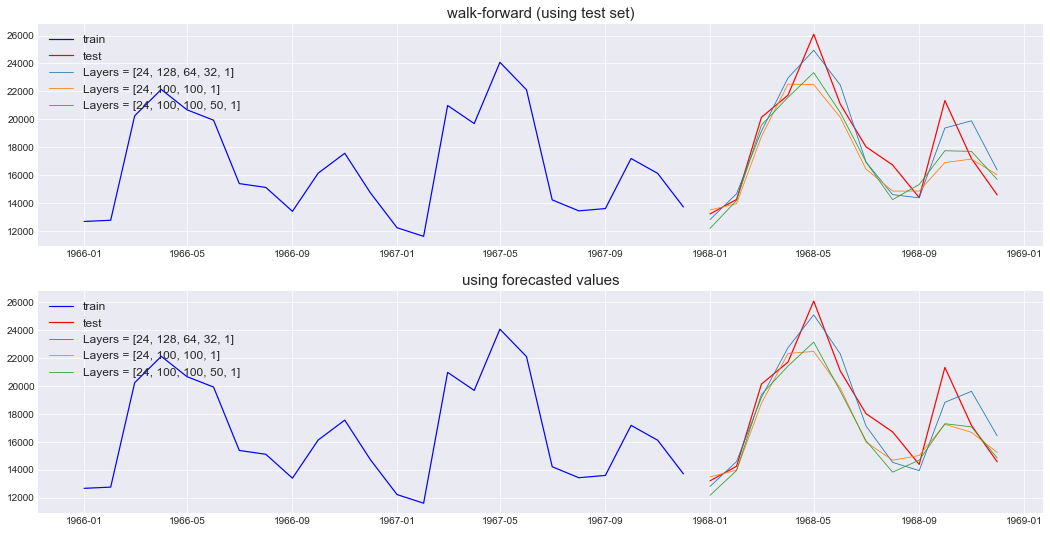

In [42]:
fig, ax = plt.subplots(2,1, figsize=(18, 9))
ax = ax.flatten()
ax[0].plot(S_train.index[-npast:], S_train.values[-npast:], 'b', linewidth=1.2, label='train')
ax[0].plot(S_test.index,  S_test.values, 'r',  linewidth=1.2, label='test')
for k in range(len(nnstruct)):
    ax[0].plot(S_test.index,  mlpwf[k], linewidth=0.8,  label='Layers = {}'.format(nnstruct[k]))
ax[0].grid()
ax[0].legend(fontsize=12)
ax[0].set_title('walk-forward (using test set)',fontsize=15) 

    
ax[1].plot(S_train.index[-npast:], S_train.values[-npast:], 'b', linewidth=1.2, label='train')
ax[1].plot(S_test.index,  S_test.values, 'r',  linewidth=1.2, label='test')
for k in range(len(nnstruct)):
    ax[1].plot(S_test.index,  mlpred[k], linewidth=0.8,  label='Layers = {}'.format(nnstruct[k]))
ax[1].grid()
ax[1].legend(fontsize=12)
ax[1].set_title('using forecasted values',fontsize=15) 

plt.show()

We plot the time series from the year 1966 (in blue) whereas the test set, i.e, the year 1968 is plotted in red. 
We can observe the three forecasts made by the neural networks